In [ ]:
# default_exp runs

In [ ]:
from oct.startup import *
from model import CapsNet
import numpy as np
import mlflow
from fastai.vision import *
import mlflow.pytorch as MLPY

### Configuration Setup

In [ ]:
import sys`

In [ ]:
sys.path.append('/workspace/oct_ca_seg/oct/pawsey/train_caps.py/')

In [ ]:
config_dict = loadConfigJSONToDict('init_config.json')
config_dict['LEARNER']['bs'] = 2
config_dict['LEARNER']['img_size'] = 256
config_dict['LEARNER']['lr']= 0.0001
config_dict['LEARNER']['num_workers'] = 1
config_dict['MODEL']['dims1'] = 16
config_dict['MODEL']['dims2'] = 32
config_dict['MODEL']['dims3'] = 64
config_dict['MODEL']['maps1'] = 8
config_dict['MODEL']['maps2'] = 12
config_dict['MODEL']['maps3'] = 16
config_dict['MODEL']['f1dims'] = 8
config_dict['MODEL']['f2dims'] = 16
config_dict['MODEL']['f1maps'] = 2
config_dict['MODEL']['f2maps'] = 2 #this should be number of classes. background, lumen => 2 etc.
config = DeepConfig(config_dict)

In [ ]:
MLPY.log_model()

Signature: saveDictToConfigJSON(dictiontary, name)
Docstring: <no docstring>
Source:   
def saveDictToConfigJSON(dictiontary, name):
    with open('/workspace/oct_ca_seg/oct/configs/'+ name, 'w') as file:
        json.dump(dictiontary, file)
File:      /workspace/oct_ca_seg/oct/oct/startup.py
Type:      function


## Dataset

In [ ]:
cocodata_path = Path('/workspace/oct_ca_seg/COCOdata/')
train_path = cocodata_path/'train/images'
valid_path = cocodata_path/'valid/images'
test_path = cocodata_path/'test/images'

### For complete dataset

In [ ]:
fn_get_y = lambda image_name: Path(image_name).parent.parent/('labels/'+Path(image_name).name)
codes = np.loadtxt(cocodata_path/'codes.txt', dtype=str)
tfms = get_transforms()
src = (SegCustomItemList
       .from_folder(cocodata_path, recurse=True, extensions='.jpg')
       .filter_by_func(lambda fname: Path(fname).parent.name == 'images', )
       .split_by_folder('train', 'valid')
       .label_from_func(fn_get_y, classes=codes))
src.transform(tfms, tfm_y=True, size=config.LEARNER.img_size)
data = src.databunch(cocodata_path,
                     bs=config.LEARNER.bs,
                     val_bs=2*config.LEARNER.bs,
                     num_workers = config.LEARNER.num_workers)
stats = [torch.tensor([0.2190, 0.1984, 0.1928]), torch.tensor([0.0645, 0.0473, 0.0434])]
data.normalize(stats);

### For converting Validation set into a mini set to experiment on

In [ ]:
fn_get_y = lambda image_name: Path(image_name).parent.parent/('labels/'+Path(image_name).name)
codes = np.loadtxt(cocodata_path/'codes.txt', dtype=str)
tfms = get_transforms()
src = (SegCustomItemList
       .from_folder(test_path, recurse=True, extensions='.jpg')
       .filter_by_func(lambda fname: Path(fname).parent.name == 'images', )
       .split_by_rand_pct(0.3)
       .label_from_func(fn_get_y, classes=codes))
src.transform(tfms, tfm_y=True, size =config.LEARNER.img_size)
data = src.databunch(test_path,
                     bs=config.LEARNER.bs,
                     val_bs=2*config.LEARNER.bs,
                     num_workers = config.LEARNER.num_workers)
stats = [torch.tensor([0.2190, 0.1984, 0.1928]), torch.tensor([0.0645, 0.0473, 0.0434])]
data.normalize(stats);

### Runs

In [ ]:
iou = partial(dice, iou=True)

In [ ]:
metrics = [sens, spec, dice, my_Dice_Loss, acc]

In [ ]:
exp_name = 'DEEPCAP'
mlflow_CB = partial(MLFlowTracker,
                    exp_name=exp_name,
                    uri='file:/workspace/oct_ca_seg/runsaves/fastai_experiments/mlruns/',
                    params=config.config_dict,
                    nb_path="/workspace/oct_ca_seg/oct/02_runs.ipynb")
deepCap = CapsNet(config.MODEL).cuda()
with mlflow.start_run():
    learner = Learner(data = data,
                      model = deepCap,
                      metrics = metrics,
                      callback_fns=mlflow_CB)
    learner.fit_one_cycle(3, slice(config.LEARNER.lr), pct_start=0.9)
    MLPY.log_model(learner.model, exp_name)

epoch,train_loss,valid_loss,sens,spec,dice,my_Dice_Loss,acc,time
0,0.430944,0.413378,0.000000,0.928463,0.000000,0.999943,1.000000,09:36
1,0.345106,0.333688,0.834166,0.987021,0.904906,0.087562,0.930438,09:37
2,0.324605,0.321946,0.910418,0.993143,0.951084,0.045312,0.929626,09:36


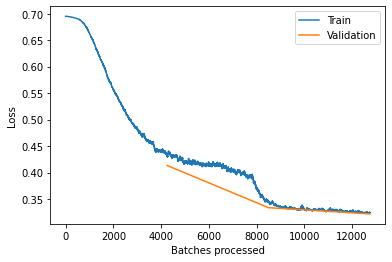

In [ ]:
learner.recorder.plot_losses()

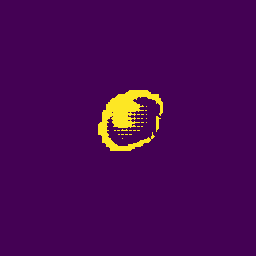

In [ ]:
learner.predict(data.valid_ds[20][1])[0]

In [ ]:
clean_tensor_lists = lambda l : [x.item() for x in l]

In [ ]:
clean_tensor_lists(learner.recorder.losses);

In [ ]:
np.array([clean_tensor_lists(x) for x in learner.recorder.metrics])

array([[0.      , 0.928463, 0.      , 0.999943, 1.      ],
       [0.834166, 0.987021, 0.904906, 0.087562, 0.930438],
       [0.910418, 0.993143, 0.951084, 0.045312, 0.929626]])

In [ ]:
learner.recorder.metrics_names

['sens', 'spec', 'dice', 'my_Dice_Loss', 'acc']

In [ ]:
learner.recorder.val_losses

[0.41337806, 0.3336882, 0.3219459]

In [ ]:
exp_name = 'FASTAI UNET'
mlflow_CB = partial(MLFlowTracker,
                    exp_name=exp_name,
                    uri='file:/workspace/oct_ca_seg/runsaves/caps_fastai/mlruns/',
                    params=config.config_dict,
                    nb_path="/workspace/oct_ca_seg/oct/02_runs.ipynb")
with mlflow.start_run():
    learner = unet_learner(data,
                           models.resnet18,
                           pretrained=False,
                           y_range=[0,1],
                           metrics=metrics,
                           callback_fns=[mlflow_CB])
    learner.fit_one_cycle(2, slice(config.LEARNER.lr), pct_start=0.8)
    MLPY.log_model(learner.model, exp_name)

epoch,train_loss,valid_loss,sens,spec,dice,acc,time
0,0.402499,0.385886,0.000000,0.927430,0.000000,1.000000,26:29
1,0.408496,0.385886,0.000000,0.927430,0.000000,1.000000,26:36


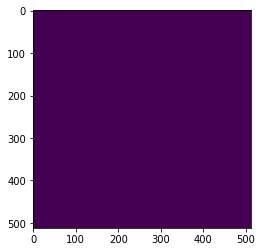

In [ ]:
plt.imshow(learner.pred_batch()[0][0])

In [ ]:
    learner = Learner(data = data,
                      model = deepCap,
                      metrics = metrics, 
                      loss_func=torch.nn.BCELoss(),
                      callback_fns=mlflow_CB)
    

In [ ]:
learner.model(data.one_batch()[0].cuda()).shape

torch.Size([4, 2, 256, 256])

In [ ]:
deepCap(data.one_batch()[0].cuda()).shape

torch.Size([4, 2, 256, 256])